# Hawkes Processes with continuous-time nonparametric baselines

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from tqdm.notebook import tqdm
import math
from scipy.stats import kstest

import pyro
from pyro.infer import SVI,Trace_ELBO,TraceMeanField_ELBO
from torch.distributions.transforms import SoftplusTransform
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta

datapath =  '/'.join(os.getcwd().split("\\")[:-1])+"/0_Auxiliary_Tools/"

torch.manual_seed(0)
print()

At this point, we know we need to find good nonparametric estimates of the baseline intensity function if we want to hope to estimate a parametric feedback function unbiasedly. We also know that piecewise constant baselines are easy to code and improve our estimates, but they are also extremely demanding of our data. Since histogram-type estimators assume that the constant baselines for discrete buckets are independent of each other, we often end up with nonsensical patterns due to massively overfitting buckets with few datapoints.  

It would be helpful to find a baseline function that is correlated over time. As it turns out, we can achieve that in continuous time with a powerful, if temperamental, set of tools: Gaussian processes.

Before examining results in our relatively elaborate counting process setting, let's consider a toy example. Let $f(x)$ be a sine function $f(x)=sin(2\pi x)$. We'll sample $Y$ as noisy points around $f(x)$, $Y\sim Normal(f,\epsilon)$. Our observed data points are a few $X$s randomly distributed in the interval $[0,3]$ and we want to extrapolate $y \in (3,6]$. We'll sample that data below. The dotted line separates training data from the holdout period.

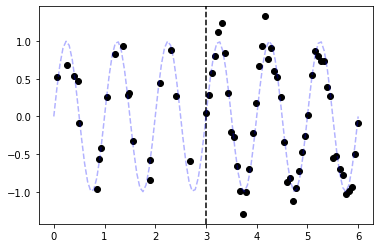

In [2]:
''' Make Data'''
train_x = dist.Uniform(0,3).sample([20]).type(torch.double)
train_x = torch.sort(train_x).values
train_y = (torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)).type(torch.double)

test_x = torch.linspace(3,6,50)
test_y = (torch.sin(test_x * (2 * math.pi)) + torch.randn(test_x.size()) * math.sqrt(0.04)).type(torch.double)

actual_x = torch.linspace(0,6,100)
actual_y = (torch.sin(actual_x * (2 * math.pi))).type(torch.double)

plt.scatter(np.hstack((train_x.numpy(),test_x.numpy())),
            np.hstack((train_y.numpy(),test_y.numpy())),
            c="black")
plt.axvline(3,c="black",linestyle="--")
plt.plot(actual_x,actual_y,linestyle='--',c="blue",alpha=0.3)
plt.show()

## 0. GP Setup


A "Gaussian process" is just a fancy way of structuring a multivariate normal distribution. The idea is that if we have $Y_1 = f(X_1)$ and want to predict $f(X_*)$ for some known $X_*$ but without knowing $f(.)$, we can do that with a multivariate normal distribution. We'll achieve that by estimating $f(X_*)|f(X_1)$.

As a starting statistical fact, if $f(.)\in R$ we can approximate any $\{f(x_1),f(x_2)\}$ arbitrarily well as $[f(x_1),f(x_2)]\sim N(\mu,\Sigma)$. To that we'll add the *assumption* that we can find some kernel function $c(x_1,x_2)$ that can fully specify $\Sigma$, in which case we have

$\begin{vmatrix}
f(x_1)\\
f(x_2)
\end{vmatrix} \sim MVN\left(\begin{vmatrix}
\mu_1\\
\mu_2
\end{vmatrix},\begin{vmatrix}
c(x_1,x_1) & c(x_1,x_2)\\
c(x_2,x_1) & c(x_2,x_2)
\end{vmatrix}\right)$


That is, the relationship between $\{f(x_1),f(x_2)\}$ can be fully captured by some relationship between $\{x_1,x_2\}$. In our care, that is indeed exactly correct. Since $f(.)$ is a periodic function, we only need to know the length of the period and the distance of $x_2$ from $x_1$ within the period. We can capture that with the periodic kernel:

$c(x_1,x_2)=exp\{\frac{-2}{h^2}sin(\frac{|x_1-x_2|\pi}{p})^2\}$

Where $p$ controls the length of the period and $h$ gives the *lengthscale*, or how much we want to smooth the relationship between $x_1,x_2$ as $|x_1-x_2|$ increases. We can code that up easily:

In [3]:
class Periodic_kernel: 
    def __init__(self,lenscale, period):
        self.lenscale = lenscale
        self.period = period
    def c(self,x1,x2):
        diff = (x1.unsqueeze(-1)-x2.unsqueeze(-2)).abs()*math.pi/self.period
        res = diff.sin().pow(2).mul(-2/self.lenscale**2).exp_()
        return res

With a choice of kernel, we can estimate the kernel parameters and the mean of the process by finding the MLE of $[f(x_1),f(x_2)]\sim N$. With that, we can estimate $f$ at any new point $X_*$ using the conveninet statistical fact that given the structure

$\begin{vmatrix}
f_*\\
f_x
\end{vmatrix} \sim MVN\left(\begin{vmatrix}
\mu_*\\
\mu_x
\end{vmatrix},\begin{vmatrix}
K_{**}& K_{*x}\\
K_{x*}& K_{xx}
\end{vmatrix}\right)$

$f_*|f\sim MVN(\mu_* + A(f_x-\mu_x),B)$ where

$A = K_{*x}K_{xx}^{-1} $

$B = K_{**}-K_{*x}K_{xx}^{-1}K_{x*}$

Up to now, everything has been fairly simple here, but I have glossed over a massive issue: how can we find $f_*|f_x$ if we do not know $f$? For our toy example, we know that $Y\sim N(f,\epsilon)$ and therefore $Y\sim MVN(\mu,K_{xx}+\epsilon I)$, so we can get the posterior distribution $p(f|y)$ by conjugacy, but what if that were not the case? Consider that $Y\sim N(g(f(X)),\epsilon)$ and that we cannot find a conjugate posterior for anything.

Let's set up a variational Bayes structure to tackle this problem. Say we have a model with the following structure:

$f\sim MVN(\mu,K_{XX})$

$Y|f\sim D(f)$

For some unspecified distribution $D$. The model has exact posterior $p(f|Y)$ which we cannot calculate. Instead, we'll try to find the variational approximation to $p(f|Y)$

$q(f) = N(f|m,S)$

Where $m,S$ are free parameters we'll estimate as well on top of $\{p,h,\epsilon,\mu\}$.

Once we have estimates for all parameters $\theta$, we can find an approximation of $f_*|f_x$ as 

$f_*|\theta\sim MVN(\mu + A(m-\mu),B+ASA^T)$

That is really all the math we need. The class below defines all GP functions we'll need.

In [4]:
class GP:
    
    def __init__(self,mean,kernel,noise=0):
        # We'll set the entire process in terms of a FIXED mean, 
        # and a kernel class with a correlation function c
        # also specify a tiny jitter term to make sure we can perform matrix inversions properly
        self.mean = mean
        self.kernel = kernel
        self.jitter = torch.tensor(1e-5).type(torch.double)
        self.noise = noise
        
    def prior(self,X): 
        # the prior is very simple. We only need to calculate c(X,X)
        K11 = self.kernel.c(X, X) + self.jitter*torch.eye(X.shape[0])
        m = self.mean.expand([X.shape[0]])
        return m, K11 
    
    def posterior_conj(self,X_1,X_2,Y_1): 
        # conjugate posterior predictive with y~N(f,e), f~MVN
        K11 = self.kernel.c(X_1,X_1) + self.jitter*torch.eye(X_1.shape[0])
        K11_= torch.inverse(K11+self.noise*torch.eye(X_1.shape[0]))
        K21 = self.kernel.c(X_2,X_1)
        K22 = self.kernel.c(X_2,X_2)
        posterior_mean = self.mean + K21.matmul(K11_).matmul(Y_1-self.mean)
        posterior_cov  = K22       - K21.matmul(K11_).matmul(K21.T) 
        return posterior_mean, posterior_cov 
    
    def posterior_cond(self,X_1,X_2,f): 
        #generalized posterior with q(f)~MVN (gives actual confidence bounds)
        K11 = self.kernel.c(X_1,X_1)+ self.jitter*torch.eye(X_1.shape[0])
        K11_= torch.inverse(K11)
        K21 = self.kernel.c(X_2,X_1)
        K22 = self.kernel.c(X_2,X_2)
        posterior_mean = self.mean + K21.matmul(K11_).matmul(f-self.mean)
        posterior_cov  = K22       - K21.matmul(K11_).matmul(K21.T) 
        return posterior_mean, posterior_cov
    
    def posterior(self,X_1,X_2,m,S): 
        #generalized posterior with q(f)~MVN (gives actual confidence bounds)
        K11 = self.kernel.c(X_1,X_1)+ self.jitter*torch.eye(X_1.shape[0])
        K11_= torch.inverse(K11)
        K21 = self.kernel.c(X_2,X_1)
        K22 = self.kernel.c(X_2,X_2)
        A = K21.matmul(K11_)
        B = K22 - K21.matmul(K11_).matmul(K21.T)
        posterior_mean = self.mean + A.matmul(m-self.mean)
        posterior_cov  = B + A.matmul(S).matmul(A.T)  
        return posterior_mean, posterior_cov

Pre-training, we can choose arbitrary kernel parameters to check our model's prior in-sample ($x\in [0,3]$). This is the "prior" because it is not conditioned on our training data. I've plotted only a few sample paths to make it easier to see how these are essentially functions over time. 

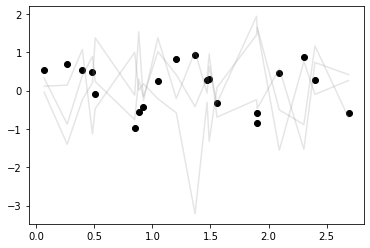

In [6]:
# GP parameters
lenscale  = torch.tensor(.1).type(torch.double)
period = torch.tensor(1.).type(torch.double)
kernel = Periodic_kernel(lenscale,period)
process_mean = torch.tensor(0.).type(torch.double)

# build GP
noise_scale = 1e-4
gp = GP(process_mean,kernel,noise_scale)

# sample from prior
prior_mean,prior_cov = gp.prior(train_x)
prior_sample = dist.MultivariateNormal(
    prior_mean,
    prior_cov+gp.noise*torch.eye(train_x.shape[0]).type(torch.double)
).sample([3])

for k in range(prior_sample.shape[0]):
    plt.plot(train_x, prior_sample[k,:],alpha=0.2,c='grey')
plt.scatter(train_x,train_y,c='black')
plt.show()

Conditioning on observed data (using conjugacy), we can also get a posterior out-of-sample ($x\in[1,3]$). Over time, this actually approximates our target function fairly well. The training process itself is a matter of picking kernel hyperparameters so this whole thing gets as close a fit as possible.

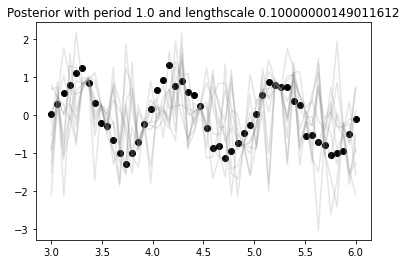

In [7]:
posterior_mean, posterior_cov = gp.posterior_conj(train_x,test_x,train_y)

posterior_sample = dist.MultivariateNormal(
    posterior_mean,
    posterior_cov+gp.noise*torch.eye(test_x.shape[0])
).sample([10])

for k in range(posterior_sample.shape[0]):
    plt.plot(test_x, posterior_sample[k,:],alpha=0.2,c='grey')
plt.scatter(test_x,test_y,c='black')
plt.title("Posterior with period {} and lengthscale {}".format(period,lenscale))
plt.show()

## 1. Simple (Conjugate) Gaussian Process Regression


We can consider the easy case, when we exploit $Y\sim MVN(\mu,K_{xx}+\epsilon I)$ first to illustrate how well the model works in the best-case scenario.

  0%|          | 0/500 [00:00<?, ?it/s]

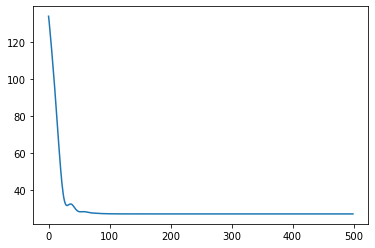

Mean         : tensor(0.1032, dtype=torch.float64)
Kernel params: tensor([0.5320, 0.7040])
Noise        : tensor([-3.9320])


In [8]:
''' Find Hyperparameters with SVI '''
class GP_Conjugate:
    def __init__(self, X,Y):
        self.X = X
        self.Y = Y

    def model(self):
        # Set prior hyperparams
        Hyper_Mean = pyro.sample("Mean"  ,dist.Normal(torch.mean(self.Y),0.01)).type(torch.double)
        Kernel_hyp = pyro.sample("Kernel",dist.Normal(torch.tensor([1.0,1.0]),torch.tensor([0.1,0.1])).to_event(1)).type(torch.double)
        Noise      = pyro.sample("Noise" ,dist.Normal(torch.tensor([-4.0]),0.1)).type(torch.double)
        
        # set GP components
        kernel = Periodic_kernel(torch.exp(Kernel_hyp[0]), torch.exp(Kernel_hyp[1]))
        gp = GP(Hyper_Mean,kernel,torch.exp(Noise))
        # get prior
        Mean,Covariance = gp.prior(self.X)
        # Calculate LL
        pyro.sample("Y", dist.MultivariateNormal(Mean,Covariance+torch.exp(Noise)*torch.eye(len(self.X))), obs=self.Y) 

    def guide(self):
        # Set variational params
        Hyper_Mean = pyro.sample("Mean"  ,dist.Delta(pyro.param("Hyper_Mean",torch.mean(self.Y)))).type(torch.double)
        Kernel_hyp = pyro.sample("Kernel",dist.Delta(pyro.param("Hyper_Kernel",torch.tensor([1.0,1.0]))).to_event(1)).type(torch.double)
        Noise      = pyro.sample("Noise" ,dist.Delta(pyro.param("Hyper_Noise",torch.tensor([-4.0])))).type(torch.double)
        
current = GP_Conjugate(train_x,train_y)
pyro.clear_param_store()
elbo= Trace_ELBO(num_particles=5)
optim = pyro.optim.Adam({'lr': 1e-2})
svi = SVI(current.model, current.guide, optim, loss=elbo)
losses = []
for step in tqdm(range(500)):
    new =svi.step()
    losses.append(new)
plt.plot(losses)
plt.show()
posterior = {k: v.data for k, v in pyro.get_param_store().items()}

print("Mean         :",posterior["Hyper_Mean"])
print("Kernel params:",posterior["Hyper_Kernel"])
print("Noise        :",posterior["Hyper_Noise"])

The model is trained! But did it work? Given our choice of hyperparameters, what does the posterior predictive distribution look like? Still using conjugacy, we can sample around the posterior predictive (red line is the predictive mean).

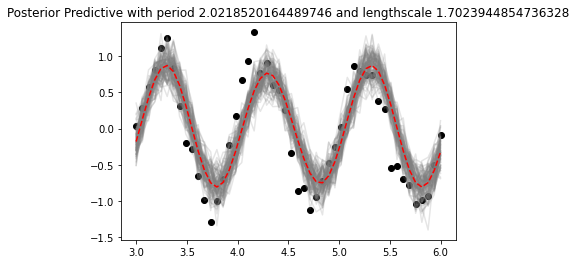

In [9]:
post_noise = torch.exp(posterior['Hyper_Noise'][0])
post_mean = posterior['Hyper_Mean']
post_lenscale = torch.exp(posterior['Hyper_Kernel'][0])
post_period = torch.exp(posterior['Hyper_Kernel'][1])

kernel = Periodic_kernel(post_lenscale, post_period)
gp = GP(post_mean,kernel,post_noise)

posterior_mean, posterior_cov = gp.posterior_conj(train_x,test_x,train_y)
posterior_sample = dist.MultivariateNormal(posterior_mean,posterior_cov + post_noise*torch.eye(test_x.shape[0])).sample([100])

for k in range(posterior_sample.shape[0]):
    plt.plot(test_x, posterior_sample[k,:],alpha=0.2,c='grey')
plt.scatter(test_x,test_y,c='black')
plt.plot(test_x,posterior_mean,c='red',linestyle='--')
plt.title("Posterior Predictive with period {} and lengthscale {}".format(post_period,post_lenscale))
plt.show()

Ok, now suppose we wanted to use the mean for forecasting. With the confidence interval noise aside, what does the mean predictive look like?

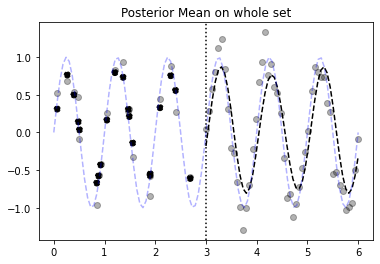

In [10]:
training_mean = gp.posterior_conj(train_x,train_x,train_y)[0]
testing_mean = gp.posterior_conj(train_x,test_x,train_y)[0]

plt.title("Posterior Mean on whole set")
plt.scatter(np.hstack((train_x,test_x)),np.hstack((train_y,test_y)),c='black',alpha = 0.3)
plt.scatter(train_x,training_mean,c='black',linestyle = '--')
plt.plot(test_x,testing_mean,c='black',linestyle = '--')
plt.axvline(3,c='black',linestyle=":")
plt.plot(actual_x,actual_y,linestyle='--',c="blue",alpha=0.3)
plt.show()

That is not bad. But of course, we've exploited both $Y\sim MVN(\mu,K_{xx}+\epsilon I)$ and conjugacy of the posterior. Suppose we do neither and instead keep the step of sampling $f$ from the GP as a separate highly stochastic function to be numerically optimized around.


## 2. Generalized Varational Gaussian Process

  0%|          | 0/1000 [00:00<?, ?it/s]

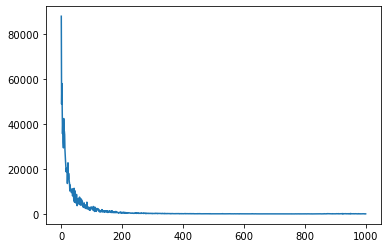

In [13]:
''' Find Hyperparameters with SVI '''
class GP_SVI:
    def __init__(self, X,Y):
        self.X = X.type(torch.double)
        self.Y = Y.type(torch.double)

    def model(self):
        # Set prior hyperparams
        Hyper_Mean = pyro.sample("Mean"  ,dist.Normal(torch.mean(self.Y),0.01)).type(torch.double)
        Kernel_hyp = pyro.sample("Kernel",dist.Normal(torch.tensor([1.0,1.0]),torch.tensor([0.1,0.1])).to_event(1)).type(torch.double)
        Noise      = pyro.sample("Noise" ,dist.Normal(torch.tensor([-4.0]),0.1)).type(torch.double)
        
        # set GP components
        kernel = Periodic_kernel(torch.exp(Kernel_hyp[0]), torch.exp(Kernel_hyp[1]))
        gp = GP(Hyper_Mean,kernel)
        
        # get prior
        Mean,Covariance = gp.prior(self.X)
        f = pyro.sample("f", dist.MultivariateNormal(Mean,Covariance))
        
        # Calculate LL
        pyro.sample("Y", dist.Normal(f,torch.exp(Noise)).to_event(1), obs=self.Y) 

    def guide(self):
        # Sample hyperparams as delta of variational params
        Hyper_Mean = pyro.sample("Mean"  ,dist.Delta(pyro.param("Hyper_Mean",torch.mean(self.Y)))).type(torch.double)
        Kernel_hyp = pyro.sample("Kernel",dist.Delta(pyro.param("Hyper_Kernel",torch.tensor([1.0,1.0]))).to_event(1)).type(torch.double)
        Noise      = pyro.sample("Noise" ,dist.Delta(pyro.param("Hyper_Noise",torch.tensor([-4.0])))).type(torch.double)
        
        # sample f as a variational param
        starting_m = torch.clone(self.Y)
        m = pyro.param("m",dist.Normal(starting_m,.1)).type(torch.double)
        kernel = Periodic_kernel(torch.exp(Kernel_hyp[0]), torch.exp(Kernel_hyp[1]))
        starting_S = torch.linalg.cholesky(kernel.c(self.X,self.X)+1e-4*torch.eye(self.X.shape[0]))
        S = pyro.param("S",starting_S,constraint=dist.constraints.lower_cholesky).type(torch.double)
        pyro.sample("f", dist.MultivariateNormal(m,scale_tril=S))
        
pyro.clear_param_store()
current = GP_SVI(train_x,train_y)
elbo= Trace_ELBO(num_particles=20)
optim = pyro.optim.Adam({'lr': 1e-2})
svi = SVI(current.model, current.guide, optim, loss=elbo)
losses = []
for step in tqdm(range(1000)):
    new =svi.step()
    losses.append(new)
plt.plot(losses)
plt.show()
posterior = {k: v.data for k, v in pyro.get_param_store().items()}

It seems to have worked. First, we should look at where our estimator has placed the approximations of $f(X)$, $m$. Remember, if we removed the noise $\epsilon$ correctly, the $m$s should fall exacly on the dotted blue line.


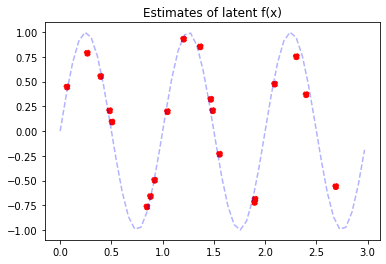

In [14]:
post_noise = torch.exp(posterior['Hyper_Noise'][0]).type(torch.double)
post_mean = posterior['Hyper_Mean'].type(torch.double)
post_lenscale = torch.exp(posterior['Hyper_Kernel'][0]).type(torch.double)
post_period = torch.exp(posterior['Hyper_Kernel'][1]).type(torch.double)

post_f = posterior['m'].type(torch.double)
post_S = posterior['S'].type(torch.double)
post_S = post_S.matmul(post_S.T)

plt.title("Estimates of latent f(x)")
plt.scatter(train_x,post_f,c='red',linestyle = '--')
plt.plot(actual_x[actual_x<3],actual_y[actual_x<3],linestyle='--',c="blue",alpha=0.3)
plt.show()

That is not awful, but there is one obvious issue when we examine the whole posterior predictive:

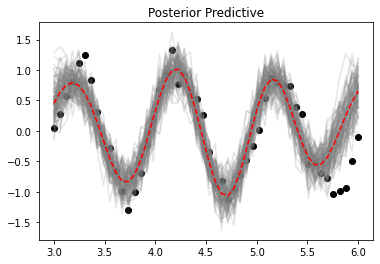

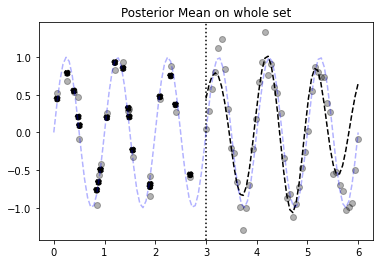

In [15]:
post_noise = torch.exp(posterior['Hyper_Noise'][0]).type(torch.double)
post_mean = posterior['Hyper_Mean'].type(torch.double)
post_lenscale = torch.exp(posterior['Hyper_Kernel'][0]).type(torch.double)
post_period = torch.exp(posterior['Hyper_Kernel'][1]).type(torch.double)

post_f = posterior['m'].type(torch.double)
post_S = posterior['S'].type(torch.double)
post_S = post_S.matmul(post_S.T)

kernel = Periodic_kernel(post_lenscale, post_period)
gp = GP(post_mean,kernel)

posterior_mean, posterior_cov = gp.posterior(train_x,test_x,post_f,post_S)
posterior_sample = dist.MultivariateNormal(posterior_mean,posterior_cov+post_noise*torch.eye(test_x.shape[0])).sample([100])

for k in range(posterior_sample.shape[0]):
    plt.plot(test_x, posterior_sample[k,:],alpha=0.2,c='grey')
plt.scatter(test_x,test_y,c='black')
plt.plot(test_x,posterior_mean,c='red',linestyle='--')
plt.title("Posterior Predictive")
plt.show()

plt.title("Posterior Mean on whole set")
plt.scatter(np.hstack((train_x,test_x)),np.hstack((train_y,test_y)),c='black',alpha = 0.3)
plt.scatter(train_x,post_f,c='black',linestyle = '--')
plt.plot(test_x,posterior_mean,c='black',linestyle = '--')
plt.axvline(3,c='black',linestyle=":")
plt.plot(actual_x,actual_y,linestyle='--',c="blue",alpha=0.3)
plt.show()

We are ever so slightly off out of sample. That is because we are overfitting the noisy data in-sample. So when there are excessively high or low observations $Y$ at the valleys and peaks of the distribution, our variational estimator also places the latent $m$s closer to those values of $Y$ than the correct latent $f(x)$. As a result, out of sample we are also either above or below the correct valleys and peaks.

That may not be a huge issue in practical applications since we are VERY close to the actual function, but there is another issue with GPs under the currect setup. The training time for a GP is $n^3$. That is because every single datapoint in training needs to be associated to every other point in our covariance estimates. 

As it turns out, we can counteract BOTH overfitting and estimation complexity by reducing the size of the training data.


## 3. Sparse Variational GP



The core idea here is that we are going to pick $u$ points, call them $Z$, to use as the basis for our estimates. More rudimentary methods involve simply picking $Z$ from the observed $X$, but we can get much better approximations if we infer $Z$ that may not be in our data. 

There are a handful of ways of doing this. A good integrative view of the main methods is provided by Quinonero-Candela et al (2007) (https://homepages.inf.ed.ac.uk/ckiw/postscript/lskm_chap.pdf). Since we are using variational inference, we can exploit the formulation of Titsias (2009)(http://proceedings.mlr.press/v5/titsias09a/titsias09a.pdf), which is a form of what Quinonero-Candela call the deterministic training conditional (DTC) approximation.

Given a distribution of $f(Z)$, we can get $f(X)|f(Z)$ using the same conditioning steps as before during training. After training, we can similarly get $f(X_*)|f(Z)$. Since we have few points to use as our basis, our model is less likely to overfit, there are fewer parameters to learn so our estimator should be more robust, and the whole procedure will scale much better with the size of our datasets.

However, there is a final and obvious problem to consider: what is $u$? Let's start by fitting the model with $u=3$ and then we'll consider how we may go about diagnozing whether that is too many or too few points. 

Technically, TWO points are sufficient to define our function: we only need information on the peak and valley of a sine function, $\{(x_{min},y_{min}),(x_{max},y_{max})\}$. However, since we only observe noisy $y$s at random $x$s, we cannot know whether our estimator will be able to find the correct 2 inducing points. With 3 or more, it is possible it will be able to approximate the correct function even with suboptimal points. 

  0%|          | 0/10000 [00:00<?, ?it/s]

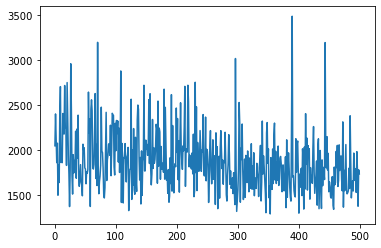

{'Hyper_Mean': tensor(0.1032, dtype=torch.float64), 'Hyper_Kernel': tensor([ 1.4615, -0.0035]), 'Hyper_Noise': tensor([-3.5550]), 'Z': tensor([1.8960, 2.5721, 2.5279], dtype=torch.float64), 'm': tensor([-0.4913, -0.4151, -0.1777], dtype=torch.float64), 'S': tensor([[0.1201, 0.0000, 0.0000],
        [0.3858, 0.1985, 0.0000],
        [0.3433, 0.1849, 0.0068]], dtype=torch.float64)}


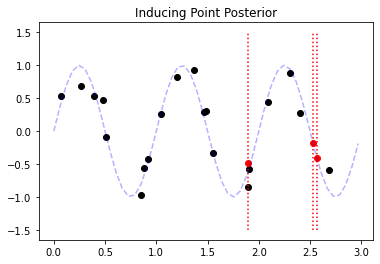

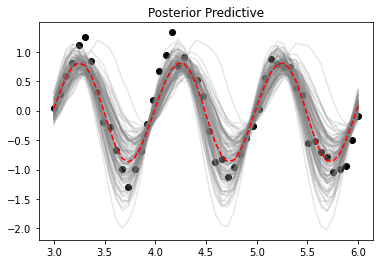

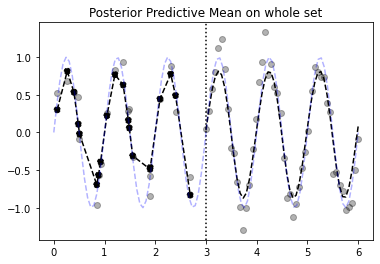

In [12]:
''' Find Hyperparameters with SVI '''
class Sparse_GP_SVI:
    def __init__(self, X,Y,u):
        self.X = X.type(torch.double)
        self.Y = Y.type(torch.double)
        self.u = u # <------------------------ Inducing points

    def model(self): # <---------------------- Same as before
        # Set prior hyperparams
        Hyper_Mean = pyro.sample("Mean"  ,dist.Normal(torch.mean(self.Y),0.01)).type(torch.double)
        Kernel_hyp = pyro.sample("Kernel",dist.Normal(torch.tensor([1.0,1.0]),torch.tensor([.1,.1])).to_event(1)).type(torch.double)
        Noise      = pyro.sample("Noise" ,dist.Normal(torch.tensor([-4.0]),0.1)).type(torch.double)
        
        # set GP components
        kernel = Periodic_kernel(torch.exp(Kernel_hyp[0]), torch.exp(Kernel_hyp[1]))
        gp = GP(Hyper_Mean,kernel)
        
        # get prior
        Mean,Covariance = gp.prior(self.X)
        f = pyro.sample("f", dist.MultivariateNormal(Mean,Covariance))
        
        # Calculate LL
        pyro.sample("Y", dist.Normal(f,torch.exp(Noise)).to_event(1), obs=self.Y) 

    def guide(self): # <---------------------- Where the magic is
        # Sample hyperparams as delta of variational params
        Hyper_Mean = pyro.sample("Mean"  ,dist.Delta(pyro.param("Hyper_Mean",torch.mean(self.Y)))).type(torch.double)
        Kernel_hyp = pyro.sample("Kernel",dist.Delta(pyro.param("Hyper_Kernel",torch.tensor([1.0,1.0]))).to_event(1)).type(torch.double)
        Noise      = pyro.sample("Noise" ,dist.Delta(pyro.param("Hyper_Noise",torch.tensor([-4.0])))).type(torch.double)

        # Set inducing point locations as variational params, start with random choices in the observed range
        Z = pyro.param("Z",dist.Uniform(self.X.min(),self.X.max()).sample([self.u])).type(torch.double)
        # set inducing point function f_z mean m as variational params, start with random values around the mean
        m = pyro.param("m",dist.Normal(Hyper_Mean,1.).sample([self.u])).type(torch.double)
        # set the convariance matrix of f_z, S_z as a variational param, start with K(Z,Z)+jitter     
        kernel = Periodic_kernel(torch.exp(Kernel_hyp[0]), torch.exp(Kernel_hyp[1]))
        starting_S = torch.linalg.cholesky(kernel.c(Z,Z)+1e-4*torch.eye(self.u))
        S = pyro.param("S",starting_S,constraint=dist.constraints.lower_cholesky).type(torch.double)
        
        # find f_x conditional on {m,S} of f_z 
        gp = GP(Hyper_Mean,kernel)
        mean,cov = gp.posterior(Z,self.X,m,S.matmul(S.T))
        pyro.sample("f", dist.MultivariateNormal(mean,cov+1e-3*torch.eye(self.X.shape[0])))

# use different learning rates for different parameters
def separate_lr(param_name):
    if param_name == 'Hyper_Kernel': return {"lr": 1e-1}
    elif param_name == 'm': return {"lr": 1e-1}
    else: return {"lr": 1e-3}

    
count_of_inducing_points = 3 #<--------- specify count of inducing points
        
pyro.clear_param_store()
current = Sparse_GP_SVI(train_x,train_y,count_of_inducing_points) 
elbo = TraceMeanField_ELBO(num_particles=10)
optim = pyro.optim.Adam(separate_lr)
svi = SVI(current.model, current.guide, optim, loss=elbo)
losses = []
for step in tqdm(range(10000)):
    new =svi.step()
    losses.append(new)
plt.plot(losses[-500:])
plt.show()
posterior = {k: v.data for k, v in pyro.get_param_store().items()}

# posterior params
print(posterior)
post_hypmean = posterior['Hyper_Mean']
post_noise = torch.exp(posterior['Hyper_Noise'][0])
post_lenscale = torch.exp(posterior['Hyper_Kernel'][0])
post_period = torch.exp(posterior['Hyper_Kernel'][1])

post_Z = posterior['Z']
post_m_z = posterior['m']
post_S_z = posterior['S'].matmul(posterior['S'].T)

plt.title("Inducing Point Posterior")
plt.vlines(post_Z,ymin=-1.5,ymax=1.5,colors="red",linestyle=":")
plt.plot(actual_x[actual_x<3],actual_y[actual_x<3],linestyle='--',c="blue",alpha=0.3)
plt.scatter(train_x,train_y,c='black')
plt.scatter(post_Z,post_m_z,c="red")
plt.show()

# posterior gp
kernel = Periodic_kernel(post_lenscale, post_period)
gp = GP(post_hypmean,kernel)

# get conditional dists based on inducing points
training_mean, posterior_cov = gp.posterior(post_Z,train_x,post_m_z,post_S_z) 
testing_mean , posterior_cov = gp.posterior(post_Z,test_x,post_m_z,post_S_z) 

posterior_test = dist.MultivariateNormal(
    testing_mean,
    posterior_cov+1e-3*torch.eye(test_x.shape[0])
).sample([100])

for k in range(posterior_test.shape[0]):
    plt.plot(test_x, posterior_test[k,:],alpha=0.2,c='grey')
plt.scatter(test_x,test_y,c='black')
plt.plot(test_x,testing_mean,c='red',linestyle='--')
plt.title("Posterior Predictive")
plt.show()

plt.title("Posterior Predictive Mean on whole set")
plt.scatter(np.hstack((train_x,test_x)),np.hstack((train_y,test_y)),c='black',alpha = 0.3)
plt.plot(test_x,testing_mean,c='black',linestyle = '--')
plt.plot(train_x,training_mean,c='black',linestyle = '--')
plt.scatter(train_x,training_mean,c='black',linestyle = '--')
plt.axvline(3,c='black',linestyle=":")
plt.plot(actual_x,actual_y,linestyle='--',c="blue",alpha=0.3)
plt.show()

That is not bad at all. Can we get better results by increasing $u$? Within sample, surely. However, we'll run a higher risk of overfitting out of sample. This at least shows us that these sparse methods can be surprisingly effective (even if in this case it took a while for the code to run). With that in mind, let's put the toy example aside and get back to our simulated data.


# 4. Point process with GP-linked intensity

First, forget about the Hawkes component. We'll try to estimate a model that assumes only that $\lambda(t)=\mu(t)$. To get that we need a new intensity function link between the GP and the point process likelihood. Let $\{\tau_j\}$ be our observations and 

$f\sim GP$

$\mu(t)=exp\{f\}$

$p(\tau_j|\mu) = \mu(\tau_j)exp\{-\int_{\tau_{j-1}}^{\tau_j}\mu(t)dt\}$

Code-wise we only need to have a class that nests $p(\tau_j|\mu)$ and a way of estimating $\int_{\tau_{j-1}}^{\tau_j}\mu(t)dt$ numerically. 

Besides that, we need to reconsider our choice of kernel. Within our OBSERVED data, there is no evidence of cyclicality a priori. Instead of the periodic kernel, we'll use the very common squared exponential kernel:

$c(x_1,x_2)=\sigma^2 exp\left\{-\frac{(x_1-x_2)^2}{2h^2}\right\}$

Below are implementations for both:

In [5]:
''' Generalized point process likelihood'''
class General_Point_Process: #<-------- takes any intensity function and calculates ll
    def __init__(self,intensity,T):
        self.intensity = intensity
        self.T = T
    def log_prob(self, timeseries):
        safety = torch.tensor(1e-9)
        h = self.intensity.density(timeseries)
        H = self.intensity.integral(0,self.T)
        ll = torch.sum(torch.log(safety + h)) - H
        return ll
    
''' GP intensity'''
class GP_intensity: #<-------- takes a GP and estimates density and integral under it
    def __init__(self,gp,Z,f_z):
        self.gp = gp
        self.Z  = Z
        self.f_z= f_z
    def density(self,t):
        return (self.gp.posterior_cond(self.Z,t,self.f_z)[0]).pow(2)
    def integral(self,t0,t1): #<----- find numerical integral with a gaussian quadrature
        p1 = (t1-t0)/2
        p2 = (t1+t0)/2
        [x,w] = np.polynomial.legendre.leggauss(10)
        x = torch.tensor(x)
        w = torch.tensor(w)
        integral = p1*torch.sum(w*(self.gp.posterior_cond(self.Z,p1*x + p2,self.f_z)[0]).pow(2))
        return integral

''' Square exp kernel '''
class SqExp_kernel: 
    def __init__(self,lenscale, sigma):
        self.lenscale = lenscale
        self.sigma = sigma
    def c(self,x1,x2):
        diff = (x1.unsqueeze(-1)-x2.unsqueeze(-2)).pow(2)
        res = diff.mul(-1/(2*self.lenscale**2)).exp_().mul(self.sigma**2)
        return res
    
'''Load data'''
dataframe = pd.read_csv(datapath + "Unidi_Sample.csv",index_col=0)
data = []
longest=0
for i in dataframe["ID"]:
    timing_string = dataframe[dataframe["ID"]==i]["Observations"][0]
    timing_string = timing_string.split(" ")[1:-1]
    timing_string =[time.strip().strip('') for time in timing_string]
    timeseries = np.array([float(k) for k in list(filter(None,timing_string))])
    data.append(torch.tensor(timeseries[timeseries<=359]).type(torch.double))
    longest = max(longest,len(timeseries))

And we can recombine that into our previous point process SVI code:

  0%|          | 0/1000 [00:00<?, ?it/s]

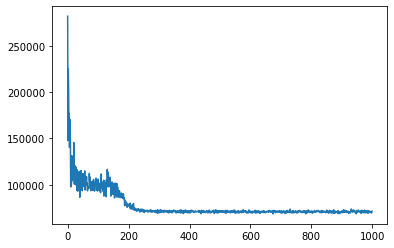

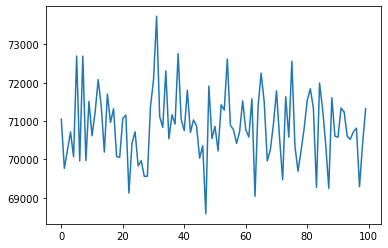

In [11]:
class GP_point_process_SVI: 
    def __init__(self,data,minibatch,u):
        self.data      = data
        event_counts = []
        for i in range(len(data)):
            event_counts.append(len(data[i]))
        self.mu = np.sqrt(np.mean(event_counts)/360)
        self.minibatch = minibatch
        self.u         = u
        # specify length of the timeseries
        self.t0 = 0
        self.T = 360
        
    def model(self):
        # set prior
        Hyper_Mean = pyro.sample("Mean"  ,dist.Normal(torch.tensor(self.mu),0.01)).type(torch.double)
        Kernel_hyp = pyro.sample("Kernel",dist.Normal(torch.tensor([6.0,0.0]),torch.tensor([.1,.1])).to_event(1)).type(torch.double)
        Z_loc      = pyro.sample("Z_loc" ,dist.Normal(dist.Uniform(self.t0,self.T).sample([self.u]),10).to_event(1)).type(torch.double)
        
        # set GP
        kernel = SqExp_kernel(torch.exp(Kernel_hyp[0]), torch.exp(Kernel_hyp[1]))
        gp = GP(Hyper_Mean,kernel)
        
        # find u at the inducing points
        Mean_z,Covariance_z = gp.prior(Z_loc)
        f_z = pyro.sample("f_z", dist.MultivariateNormal(Mean_z,Covariance_z))
        
        # only subsample a few users
        for i in pyro.plate("Obs",len(data),subsample_size=self.minibatch):
            intensity = GP_intensity(gp,Z_loc,f_z)
            process = General_Point_Process(intensity,self.T)
            pyro.sample('Points_{}'.format(i), process,obs=self.data[i])
        
    def guide(self):
        Hyper_Mean = pyro.sample("Mean"  ,dist.Delta(pyro.param("Hyper_Mean",torch.tensor(self.mu)))).type(torch.double)
        Kernel_hyp = pyro.sample("Kernel",dist.Delta(pyro.param("Hyper_Kernel",torch.tensor([6.0,0.0]))).to_event(1)).type(torch.double)
        Z = pyro.sample("Z_loc",dist.Delta(pyro.param("Z",dist.Uniform(self.t0,self.T).sample([self.u])).type(torch.double)).to_event(1))
        
        # set GP
        kernel = SqExp_kernel(torch.exp(Kernel_hyp[0]), torch.exp(Kernel_hyp[1]))
        gp = GP(Hyper_Mean,kernel)
        
        # find u at inducing points
        m = pyro.param("m",dist.Normal(Hyper_Mean,.1).sample([self.u])).type(torch.double)
        S = pyro.param("S",torch.linalg.cholesky(kernel.c(Z,Z)+1e-4*torch.eye(self.u)),constraint=dist.constraints.lower_cholesky).type(torch.double)
        pyro.sample("f_z", dist.MultivariateNormal(m,scale_tril=S))
        
            
# use different learning rates for different parameters
def separate_lr(param_name):
    lrd = 1e-1**(1/1000)
    if param_name == 'Hyper_Kernel': return {"lr": 1e-2,"lrd":lrd}
    elif param_name == 'Z': return {"lr": 5e-2,"lrd":lrd}
    else: return {"lr": 5e-2,"lrd":lrd}

    
count_of_inducing_points = 4 #<--------- specify count of inducing points
minibatch=10
n_particles = 10
n_steps = 1000

pyro.clear_param_store()
current = GP_point_process_SVI(data,minibatch,count_of_inducing_points) 
elbo = TraceMeanField_ELBO(num_particles=n_particles)
optim = pyro.optim.ClippedAdam(separate_lr)
svi = SVI(current.model, current.guide, optim, loss=elbo)
losses = []
for step in tqdm(range(n_steps)):
    new =svi.step()
    losses.append(new)
plt.plot(losses)
plt.show()
plt.plot(losses[-100:])
plt.show()
posterior = {k: v.data for k, v in pyro.get_param_store().items()}

But how well did we do?

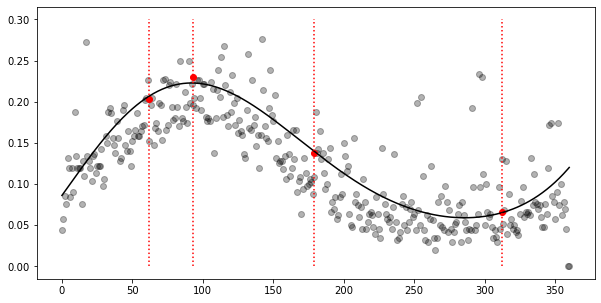

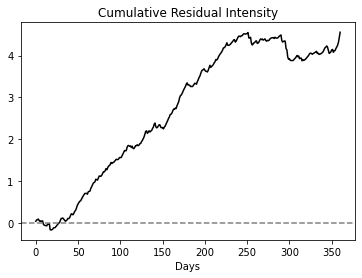

In [12]:
# find mean empirical intensity
T=360
timeseries = np.zeros(T+1)
for i in range(len(data)):
    timeseries[torch.floor(data[i]).numpy().astype(int)]+=1
timeseries=timeseries/len(data)

# posterior gp
post_hypmean = posterior['Hyper_Mean'].type(torch.double)
post_kernel = torch.exp(posterior['Hyper_Kernel']).type(torch.double)
post_Z = posterior['Z'].type(torch.double)
post_m_z = posterior['m'].type(torch.double)
post_S_z = posterior['S'].matmul(posterior['S'].T).type(torch.double)
timesteps = torch.arange(0,T+1).type(torch.double)
kernel = SqExp_kernel(post_kernel[0], post_kernel[1])
gp = GP(post_hypmean,kernel)
model_intensity = (gp.posterior_cond(post_Z,timesteps,post_m_z)[0]).pow(2)
 
fig, ax = plt.subplots(nrows=1,figsize=(10, 5))
ax.scatter(timesteps,timeseries, color = "black", alpha=0.3,label="Empirical")
ax.plot(timesteps, model_intensity, color = "black", label="Inferred")
ax.vlines(post_Z,ymin=0.,ymax=.3,colors="red",linestyle=":")
ax.scatter(post_Z,(post_m_z).pow(2),c="red")
plt.show()

residual = model_intensity.numpy()-timeseries
plt.plot(np.cumsum(residual),color='black')
plt.axhline(0,linestyle='--',color='grey')
plt.title("Cumulative Residual Intensity")
plt.xlabel("Days")
plt.show()

Not bad! But we have a clear problem with correlated errors still. We can see that better using the transform dist autocorrelation plot. It doesn't look AWFUL, but there is noticeable pooling of the transform time distribution in the low and high values. Perhaps less noticeable, the $C_t$ to $C_{t+1}$ scatterplot shows a higher density in the $[0,.2] \times [0,.2]$ range, which is the mark of underestimated positive momentum.

  0%|          | 0/100 [00:00<?, ?it/s]

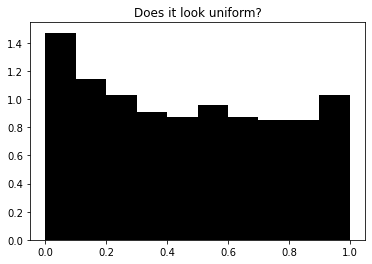

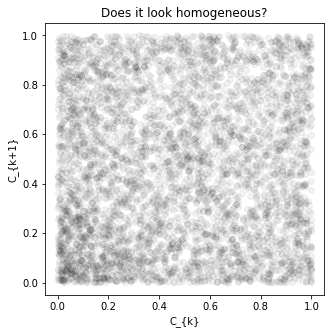

In [13]:
gp = GP(post_hypmean,kernel)
gpi = GP_intensity(gp,post_Z,post_m_z)

all_transform_times = np.zeros(1)
for i in tqdm(range(100)):
    transform_times = np.zeros(len(data[i]))
    for t in range(len(transform_times)):
        transform_times[t] += gpi.integral(0,data[i][t])
    transform_times[1:]-=transform_times[:-1]
    all_transform_times = np.hstack((all_transform_times,transform_times[1:]))
    
# get the transform time CDFs 
C = 1-np.exp(-all_transform_times[1:])
plt.hist(C,color="black",density=True)
plt.title("Does it look uniform?")
plt.show()

# plot C_{k} vs C_{k+1} to see if there's unaccounted for endogeneity 
fig, ax = plt.subplots(nrows=1,figsize=(5,5))
ax.scatter(C[:-1],C[1:],color="black",alpha=0.05)
ax.set_ylabel("C_{k+1}")
ax.set_xlabel("C_{k}")
ax.set_title("Does it look homogeneous?")
plt.show()

# 5. Hawkes Process with nonparametric continuous baseline

Finally, it is trivial to combine that nonparametric estimator with an explict parametric feedback system to get the full nonparametric Hawkes process.

  0%|          | 0/500 [00:00<?, ?it/s]

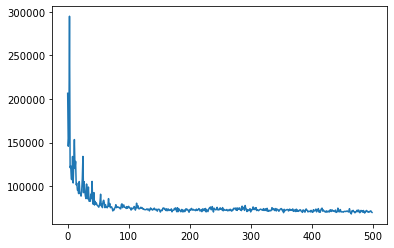

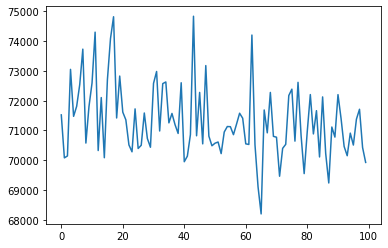

In [17]:
''' Hawkes process likelihood'''
class Hawkes_Process:
    def __init__(self,intensity,feedback,T):
        self.intensity = intensity
        self.feedback = feedback
        self.T = T
    def log_prob(self, timeseries):
        safety = torch.tensor(1e-9)
        h = self.intensity.density(timeseries) + self.feedback.density(timeseries,timeseries)
        H = self.intensity.integral(0,self.T ) + self.feedback.cumulative(self.T,timeseries)
        ll = torch.sum(torch.log(safety + h)) - H
        return ll
    
class exp_kernel:
    def __init__(self,params):
        self.α = params[0]
        self.β = params[1]
        
    def density(self,t,history):
        history_deltas = t.reshape(-1,1) - history
        timing_mask = history_deltas>0
        raw = self.α*torch.exp(-self.β*(history_deltas*timing_mask))
        return torch.sum(raw*timing_mask,1)
    
    def cumulative(self,T,history):
        timing_mask = T-history>0
        return torch.sum(timing_mask*(self.α/self.β)*(1-torch.exp(-self.β*(T-history))))
    
    
class GP_point_process_SVI: 
    def __init__(self,data,minibatch,u):
        self.data      = data
        event_counts = []
        for i in range(len(data)):
            event_counts.append(len(data[i]))
        self.mu = np.sqrt(np.mean(event_counts)/360)
        self.minibatch = minibatch
        self.u         = u
        # specify length of the timeseries
        self.t0 = 0
        self.T = 360
        
    def model(self):
        # set prior
        Hyper_Mean  = pyro.sample("Mean"        ,dist.Normal(torch.tensor(self.mu),0.01)).type(torch.double)
        Kernel_hyp  = pyro.sample("Kernel"      ,dist.Normal(torch.tensor([6.0,0.0]),torch.tensor([.1,.1])).to_event(1)).type(torch.double)
        Feedback_hyp= pyro.sample("Feedback_hyp",dist.Normal(torch.tensor([-1.,-1.,0.,-1.]),torch.tensor([.1,.1,.1,.1])).to_event(1)).type(torch.double)
        Z_loc       = pyro.sample("Z_loc"       ,dist.Normal(dist.Uniform(self.t0,self.T).sample([self.u]),10).to_event(1)).type(torch.double)
        
        # set GP
        kernel = SqExp_kernel(torch.exp(Kernel_hyp[0]), torch.exp(Kernel_hyp[1]))
        gp = GP(Hyper_Mean,kernel)
        
        # find u at the inducing points
        Mean_z,Covariance_z = gp.prior(Z_loc)
        f_z = pyro.sample("f_z", dist.MultivariateNormal(Mean_z,Covariance_z))
        
        # only subsample a few users
        for i in pyro.plate("Obs",len(data),subsample_size=self.minibatch):
            feedback_params_1 = pyro.sample("Feedback_1_{}".format(i),dist.Normal(Feedback_hyp[0],torch.exp(Feedback_hyp[1])))
            feedback_params_2 = pyro.sample("Feedback_2_{}".format(i),dist.Normal(Feedback_hyp[2],torch.exp(Feedback_hyp[1])))
            feedback = exp_kernel([torch.exp(feedback_params_1),torch.exp(feedback_params_2)])
            intensity = GP_intensity(gp,Z_loc,f_z)
            process = Hawkes_Process(intensity,feedback,self.T)
            pyro.sample('Points_{}'.format(i), process,obs=self.data[i])
        
    def guide(self):
        Hyper_Mean   = pyro.sample("Mean"        ,dist.Delta(pyro.param("Hyper_Mean"    ,torch.tensor(self.mu)))).type(torch.double)
        Kernel_hyp   = pyro.sample("Kernel"      ,dist.Delta(pyro.param("Hyper_Kernel"  ,torch.tensor([6.0,0.0]))).to_event(1)).type(torch.double)
        Feedback_hyp = pyro.sample("Feedback_hyp",dist.Delta(pyro.param("Hyper_Feedback",torch.tensor([-1.,-1.,0.,-1.]))).to_event(1)).type(torch.double)
        Z            = pyro.sample("Z_loc"       ,dist.Delta(pyro.param("Z",dist.Uniform(self.t0,self.T).sample([self.u])).type(torch.double)).to_event(1))
        
        # set GP
        kernel = SqExp_kernel(torch.exp(Kernel_hyp[0]), torch.exp(Kernel_hyp[1]))
        gp = GP(Hyper_Mean,kernel)
        
        # find u at inducing points
        m = pyro.param("m",dist.Normal(Hyper_Mean,.1).sample([self.u])).type(torch.double)
        S = pyro.param("S",torch.linalg.cholesky(kernel.c(Z,Z)+1e-4*torch.eye(self.u)),constraint=dist.constraints.lower_cholesky).type(torch.double)
        pyro.sample("f_z", dist.MultivariateNormal(m,scale_tril=S))
        
        for i in pyro.plate("Obs",len(data),subsample_size=self.minibatch):
            feedback_params_1 = pyro.sample("Feedback_1_{}".format(i),dist.Normal(Feedback_hyp[0],torch.exp(Feedback_hyp[1])))
            feedback_params_2 = pyro.sample("Feedback_2_{}".format(i),dist.Normal(Feedback_hyp[2],torch.exp(Feedback_hyp[1])))
            
            
# use different learning rates for different parameters
def separate_lr(param_name):
    lrd = 1e-1**(1/1000)
    if param_name == 'Hyper_Kernel': return {"lr": 1e-2,"lrd":lrd}
    elif param_name == 'Z': return {"lr": 1e-1,"lrd":lrd}
    elif param_name == 'Feedback_hyp': return {"lr": 1e-2,"lrd":lrd}
    else: return {"lr": 1e-1,"lrd":lrd}

    
count_of_inducing_points = 4 #<--------- specify count of inducing points
minibatch=10
n_particles = 5
n_steps = 500

pyro.clear_param_store()
current = GP_point_process_SVI(data,minibatch,count_of_inducing_points) 
elbo = TraceMeanField_ELBO(num_particles=n_particles)
optim = pyro.optim.ClippedAdam(separate_lr)
svi = SVI(current.model, current.guide, optim, loss=elbo)
losses = []
for step in tqdm(range(n_steps)):
    new =svi.step()
    losses.append(new)
plt.plot(losses)
plt.show()
plt.plot(losses[-100:])
plt.show()
posterior = {k: v.data for k, v in pyro.get_param_store().items()}

First, let's check the quality of fit, then whether the recovered parameters are correct. The intensity plot is close to what we'd expect. More importantly, the transform times are ALMOST uniform and their autocorrelation plot is homogeneous - the previous pooling of extreme values is gone.

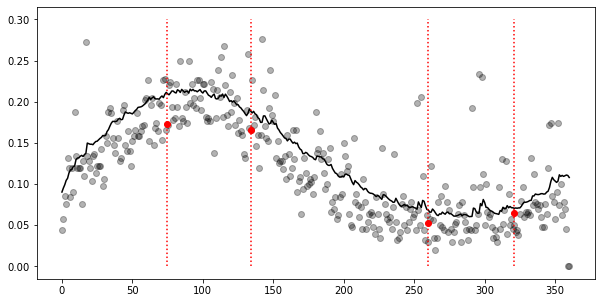

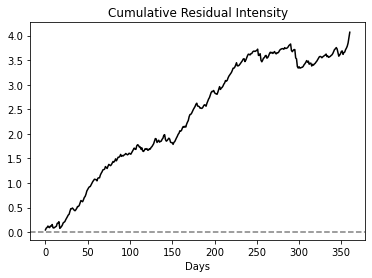

  0%|          | 0/100 [00:00<?, ?it/s]

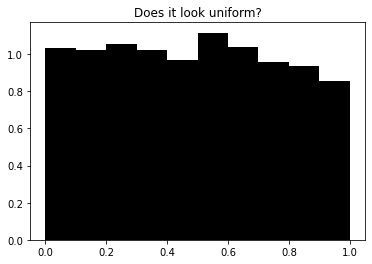

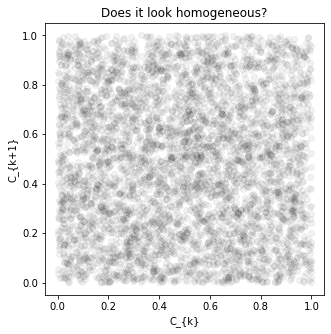

In [18]:
# find mean empirical intensity
T=360
timeseries = np.zeros(T+1)
for i in range(len(data)):
    timeseries[torch.floor(data[i]).numpy().astype(int)]+=1
timeseries=timeseries/len(data)

# posterior gp
post_hypmean = posterior['Hyper_Mean'].type(torch.double)
post_kernel = torch.exp(posterior['Hyper_Kernel']).type(torch.double)
post_Z = posterior['Z'].type(torch.double)
post_m_z = posterior['m'].type(torch.double)
post_S_z = posterior['S'].matmul(posterior['S'].T).type(torch.double)
timesteps = torch.arange(0,T+1).type(torch.double)
kernel = SqExp_kernel(post_kernel[0], post_kernel[1])
gp = GP(post_hypmean,kernel)
baseline = (gp.posterior_cond(post_Z,timesteps,post_m_z)[0]).pow(2)
 
# posterior feedback
post_feedback = torch.exp(posterior['Hyper_Feedback']).type(torch.double)
feedback = exp_kernel(post_feedback[[0,2]])
feedback_intensity = torch.zeros(T+1)
for i in range(len(data)):
    feedback_intensity += feedback.density(torch.arange(T+1),data[i])
feedback_intensity = feedback_intensity/len(data)

model_intensity = (gp.posterior_cond(post_Z,timesteps,post_m_z)[0]).pow(2) + feedback_intensity


fig, ax = plt.subplots(nrows=1,figsize=(10, 5))
ax.scatter(timesteps,timeseries, color = "black", alpha=0.3,label="Empirical")
ax.plot(timesteps, model_intensity, color = "black", label="Inferred")
ax.vlines(post_Z,ymin=0.,ymax=.3,colors="red",linestyle=":")
ax.scatter(post_Z,(post_m_z).pow(2),c="red")
plt.show()

residual = model_intensity.numpy()-timeseries
plt.plot(np.cumsum(residual),color='black')
plt.axhline(0,linestyle='--',color='grey')
plt.title("Cumulative Residual Intensity")
plt.xlabel("Days")
plt.show()

gpi = GP_intensity(gp,post_Z,post_m_z)

all_transform_times = np.zeros(1)
for i in tqdm(range(100)):
    transform_times = np.zeros(len(data[i]))
    for t in range(len(transform_times)):
        transform_times[t] += gpi.integral(0,data[i][t]) + feedback.cumulative(data[i][t],data[i])
    transform_times[1:]-=transform_times[:-1]
    all_transform_times = np.hstack((all_transform_times,transform_times[1:]))
    
# get the transform time CDFs 
C = 1-np.exp(-all_transform_times[1:])
plt.hist(C,color="black",density=True)
plt.title("Does it look uniform?")
plt.show()

# plot C_{k} vs C_{k+1} to see if there's unaccounted for endogeneity 
fig, ax = plt.subplots(nrows=1,figsize=(5,5))
ax.scatter(C[:-1],C[1:],color="black",alpha=0.05)
ax.set_ylabel("C_{k+1}")
ax.set_xlabel("C_{k}")
ax.set_title("Does it look homogeneous?")
plt.show()

And now FINALLY we can check that we are very close to the correct feedback parameters. It is, afterall, possible to get close to correct estimates in these settings, even if it is not easy. However, although we got very close to the correct answer, it took a lot of tinkering with estimation settings to get here. There are many local optima here, so we must be cautious throughout and persist in re-running the estimation loop if diagnostic plots don't look correct.

In [19]:
s1 = torch.exp(dist.Normal(posterior['Hyper_Feedback'][0],torch.exp(posterior['Hyper_Feedback'][1])).sample([1000]))
s2 = torch.exp(dist.Normal(posterior['Hyper_Feedback'][2],torch.exp(posterior['Hyper_Feedback'][3])).sample([1000]))
print("Estimated")
print("α) mean:",torch.mean(s1).round(decimals=2).numpy(), " sd:",torch.std(s1).round(decimals=2).numpy())
print("β) mean:",torch.mean(s2).round(decimals=2).numpy(), " sd:",torch.std(s2).round(decimals=2).numpy())
print("Mean effect size: ",torch.mean(s1/s2).round(decimals=2).numpy())
a1=[];a2=[]
for i in range(len(data)):
    a1.append(float(dataframe["Params"].iloc[i].split("[")[1].split(",")[0]))
    a2.append(float(dataframe["Params"].iloc[0].split("]")[0].split(",")[-1]))
a1=np.array(a1)
a2=np.array(a2)
print("Actual")
print("α) mean:",np.mean(a1).round(decimals=2), " sd:",np.std(a1).round(decimals=2))
print("β) mean:",np.mean(a2).round(decimals=2), " sd:",np.std(a2).round(decimals=2))
print("Mean effect size: ",np.mean(a1/a2).round(decimals=2))

Estimated
α) mean: 0.08  sd: 0.01
β) mean: 0.53  sd: 0.2
Mean effect size:  0.16
Actual
α) mean: 0.06  sd: 0.03
β) mean: 0.5  sd: 0.0
Mean effect size:  0.11


# Bibliography

https://towardsdatascience.com/variational-gaussian-process-what-to-do-when-things-are-not-gaussian-41197039f3d4

https://towardsdatascience.com/sparse-and-variational-gaussian-process-what-to-do-when-data-is-large-2d3959f430e7

Lloyd, C., Gunter, T., Osborne, M., & Roberts, S. (2015). Variational Inference for Gaussian Process Modulated Poisson Processes. Proceedings of the 32nd International Conference on Machine Learning, 1814–1822. https://proceedings.mlr.press/v37/lloyd15.html

Quinonero-Candela, J., Ramussen, C. E., & Williams, C. K. I. (n.d.). Approximation Methods for Gaussian Process Regression. 24.

Titsias, M. (2009). Variational Learning of Inducing Variables in Sparse Gaussian Processes. Proceedings of the Twelth International Conference on Artificial Intelligence and Statistics, 567–574. https://proceedings.mlr.press/v5/titsias09a.html

Zhang, R., Walder, C., & Rizoiu, M.-A. (2020). Variational Inference for Sparse Gaussian Process Modulated Hawkes Process. Proceedings of the AAAI Conference on Artificial Intelligence, 34(04), 6803–6810. https://doi.org/10.1609/aaai.v34i04.6160

Zhang, R., Walder, C., Rizoiu, M.-A., & Xie, L. (2022). Efficient Non-parametric Bayesian Hawkes Processes (arXiv:1810.03730). arXiv. https://doi.org/10.48550/arXiv.1810.03730

Zhou, F., Li, Z., Fan, X., Wang, Y., Sowmya, A., & Chen, F. (2019). Efficient EM-Variational Inference for Hawkes Process (arXiv:1905.12251). arXiv. http://arxiv.org/abs/1905.12251

Zhou, F., Li, Z., Fan, X., Wang, Y., Sowmya, A., & Chen, F. (2020). Efficient Inference for Nonparametric Hawkes Processes Using Auxiliary Latent Variables. Journal of Machine Learning Research, 21(241), 1–31.